In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, shape
from haversine import haversine, Unit
import pandas as pd
from shapely.geometry import MultiPoint
import json
import datetime


In [115]:
df_fire = pd.read_csv('data/ca_daily_fire_2000_03252022.csv')
df_travel = pd.read_csv('data/california_jul_nov_2019.csv', index_col=0)

In [116]:
df_fire = df_fire[df_fire['year']>= 2019]
df_fire = df_fire[df_fire['year']<= 2021]

In [117]:
df_fire

,latitude,longitude,acq_date,satellite,instrument,confidence,year,month
180,32.519249,-114.732300,2021-08-02,N,VIIRS,100,2021,8
184,32.521088,-114.731140,2021-08-02,N,VIIRS,50,2021,8
190,32.525978,-114.735359,2021-08-02,N,VIIRS,50,2021,8
211,32.533710,-114.799103,2020-02-29,N,VIIRS,50,2020,2
225,32.536598,-114.718857,2020-07-15,N,VIIRS,50,2020,7
...,...,...,...,...,...,...,...,...
1116850,41.999905,-123.618187,2020-09-19,N,VIIRS,50,2020,9
1116851,41.999920,-123.597160,2020-09-09,N,VIIRS,50,2020,9
1116852,41.999920,-123.407028,2020-09-10,N,VIIRS,50,2020,9
1116857,41.999950,-123.621155,2020-09-20,N,VIIRS,50,2020,9


In [118]:

# Define coordinates for the three wildfires
czu_lightning_complex_coords = (37.183556, -122.244556)
kincaid_fire_coords = (38.792458, -122.780053)
august_complex_coords = (39.765, -122.673)

# Define a threshold distance within which a record is considered to belong to a wildfire
threshold_distance = 2

# Compute distance to each wildfire and filter the records based on threshold distance
df_fire_czu = df_fire.copy()
df_fire_czu['dist_to_czu'] = df_fire_czu.apply(lambda row: haversine((row['latitude'], row['longitude']), czu_lightning_complex_coords), axis=1)
df_fire_czu = df_fire_czu[df_fire_czu['dist_to_czu'] <= threshold_distance]

df_fire_kincaid = df_fire.copy()
df_fire_kincaid['dist_to_kincaid'] = df_fire_kincaid.apply(lambda row: haversine((row['latitude'], row['longitude']), kincaid_fire_coords), axis=1)
df_fire_kincaid = df_fire_kincaid[df_fire_kincaid['dist_to_kincaid'] <= threshold_distance]

df_fire_august = df_fire.copy()
df_fire_august['dist_to_august'] = df_fire_august.apply(lambda row: haversine((row['latitude'], row['longitude']), august_complex_coords), axis=1)
df_fire_august = df_fire_august[df_fire_august['dist_to_august'] <= threshold_distance]



In [119]:
# Convert acq_date to datetime
df_fire_czu['acq_date'] = pd.to_datetime(df_fire_czu['acq_date'])

# Define the date range
start_date = pd.to_datetime('2020-08-16')
end_date = pd.to_datetime('2020-09-22')

# Filter df_fire_czu by date range
df_fire_czu = df_fire_czu[(df_fire_czu['acq_date'] >= start_date) & (df_fire_czu['acq_date'] <= end_date)]


In [120]:
df_fire_czu

,latitude,longitude,acq_date,satellite,instrument,confidence,year,month,dist_to_czu
300700,37.165900,-122.247000,2020-08-19,Terra,MODIS,93,2020,8,1.975166
300710,37.166004,-122.240814,2020-08-19,N,VIIRS,50,2020,8,1.979656
300716,37.166065,-122.245987,2020-08-19,N,VIIRS,50,2020,8,1.949041
300786,37.166679,-122.242325,2020-08-19,N,VIIRS,50,2020,8,1.887021
300834,37.167110,-122.246315,2020-08-19,N,VIIRS,50,2020,8,1.835343
...,...,...,...,...,...,...,...,...,...
305592,37.199299,-122.244759,2020-08-20,N,VIIRS,50,2020,8,1.750637
305672,37.199863,-122.236153,2020-08-19,N,VIIRS,50,2020,8,1.960088
305699,37.200100,-122.251100,2020-08-20,Terra,MODIS,84,2020,8,1.928778
305734,37.200436,-122.249359,2020-08-21,N,VIIRS,50,2020,8,1.924587


In [121]:
# Convert acq_date to datetime
df_fire_kincaid['acq_date'] = pd.to_datetime(df_fire_kincaid['acq_date'])

# Define the date range
start_date = pd.to_datetime('2019-10-23')
end_date = pd.to_datetime('2019-11-06')

# Filter df_fire_czu by date range
df_fire_kincaid = df_fire_kincaid[(df_fire_kincaid['acq_date'] >= start_date) & (df_fire_kincaid['acq_date'] <= end_date)]

In [122]:
df_fire_kincaid

,latitude,longitude,acq_date,satellite,instrument,confidence,year,month,dist_to_kincaid
518225,38.775566,-122.775024,2019-10-24,N,VIIRS,50,2019,10,1.928225
518247,38.775719,-122.780624,2019-10-24,N,VIIRS,50,2019,10,1.861952
518274,38.775879,-122.786545,2019-10-24,N,VIIRS,50,2019,10,1.927472
518379,38.776493,-122.775215,2019-10-24,N,VIIRS,50,2019,10,1.824086
518554,38.777489,-122.775085,2019-10-24,N,VIIRS,50,2019,10,1.719278
...,...,...,...,...,...,...,...,...,...
523032,38.808033,-122.789383,2019-10-25,N,VIIRS,50,2019,10,1.911297
523090,38.808350,-122.772789,2019-10-26,N,VIIRS,50,2019,10,1.875883
523147,38.808700,-122.778700,2019-10-26,Terra,MODIS,100,2019,10,1.809832
523167,38.808857,-122.787376,2019-10-25,N,VIIRS,100,2019,10,1.930756


In [123]:
df_fire_august

,latitude,longitude,acq_date,satellite,instrument,confidence,year,month,dist_to_august
643634,39.747101,-122.671097,2020-08-18,N,VIIRS,50,2020,8,1.996918
643640,39.747166,-122.675446,2020-08-18,N,VIIRS,100,2020,8,1.994046
643837,39.748280,-122.671112,2020-08-18,N,VIIRS,100,2020,8,1.866174
643887,39.748585,-122.676743,2020-08-18,N,VIIRS,100,2020,8,1.853099
643980,39.749092,-122.676956,2020-08-18,N,VIIRS,50,2020,8,1.800926
...,...,...,...,...,...,...,...,...,...
649653,39.781600,-122.677800,2020-08-22,Terra,MODIS,89,2020,8,1.890873
649698,39.781803,-122.667618,2020-08-20,N,VIIRS,50,2020,8,1.924194
649700,39.781807,-122.680550,2020-08-22,N,VIIRS,50,2020,8,1.977108
649745,39.782100,-122.678800,2020-08-22,Aqua,MODIS,54,2020,8,1.964983


In [124]:
df_fire_czu

,latitude,longitude,acq_date,satellite,instrument,confidence,year,month,dist_to_czu
300700,37.165900,-122.247000,2020-08-19,Terra,MODIS,93,2020,8,1.975166
300710,37.166004,-122.240814,2020-08-19,N,VIIRS,50,2020,8,1.979656
300716,37.166065,-122.245987,2020-08-19,N,VIIRS,50,2020,8,1.949041
300786,37.166679,-122.242325,2020-08-19,N,VIIRS,50,2020,8,1.887021
300834,37.167110,-122.246315,2020-08-19,N,VIIRS,50,2020,8,1.835343
...,...,...,...,...,...,...,...,...,...
305592,37.199299,-122.244759,2020-08-20,N,VIIRS,50,2020,8,1.750637
305672,37.199863,-122.236153,2020-08-19,N,VIIRS,50,2020,8,1.960088
305699,37.200100,-122.251100,2020-08-20,Terra,MODIS,84,2020,8,1.928778
305734,37.200436,-122.249359,2020-08-21,N,VIIRS,50,2020,8,1.924587


In [125]:
# Convert acq_date to datetime
df_fire_august['acq_date'] = pd.to_datetime(df_fire_august['acq_date'])

# Define the date range
start_date = pd.to_datetime('2020-08-16')
end_date = pd.to_datetime('2020-11-12')

# Filter df_fire_czu by date range
df_fire_august = df_fire_august[(df_fire_august['acq_date'] >= start_date) & (df_fire_august['acq_date'] <= end_date)]

In [126]:
df_fire_august

,latitude,longitude,acq_date,satellite,instrument,confidence,year,month,dist_to_august
643634,39.747101,-122.671097,2020-08-18,N,VIIRS,50,2020,8,1.996918
643640,39.747166,-122.675446,2020-08-18,N,VIIRS,100,2020,8,1.994046
643837,39.748280,-122.671112,2020-08-18,N,VIIRS,100,2020,8,1.866174
643887,39.748585,-122.676743,2020-08-18,N,VIIRS,100,2020,8,1.853099
643980,39.749092,-122.676956,2020-08-18,N,VIIRS,50,2020,8,1.800926
...,...,...,...,...,...,...,...,...,...
649653,39.781600,-122.677800,2020-08-22,Terra,MODIS,89,2020,8,1.890873
649698,39.781803,-122.667618,2020-08-20,N,VIIRS,50,2020,8,1.924194
649700,39.781807,-122.680550,2020-08-22,N,VIIRS,50,2020,8,1.977108
649745,39.782100,-122.678800,2020-08-22,Aqua,MODIS,54,2020,8,1.964983


In [127]:
def mark_blocked_paths(df_fire, df_travel, save_path):
    same_origin_destination = df_travel[df_travel['lng_o'] == df_travel['lng_d']].shape[0]
    total = df_travel.shape[0]
    print(f"Proportion of routes with same origin and destination: {same_origin_destination / total}")

    # GeoDataFrame for travel data
    geometry_travel = [LineString([(row['lng_o'], row['lat_o']), (row['lng_d'], row['lat_d'])]) for idx, row in df_travel.iterrows()]
    gdf_travel = gpd.GeoDataFrame(df_travel, geometry=geometry_travel)

    # For each unique date in the fire data, create a Polygon that encompasses all points for that date
    df_fire['acq_date'] = pd.to_datetime(df_fire['acq_date'])
    unique_dates = df_fire['acq_date'].dt.date.unique()
    fire_polygons = []
    for date in unique_dates:
        df_date = df_fire[df_fire['acq_date'].dt.date == date]
        fire_points = MultiPoint([xy for xy in zip(df_date['longitude'], df_date['latitude'])])
        fire_polygon = fire_points.convex_hull
        fire_polygons.append(fire_polygon)

    # GeoDataFrame for fire data
    gdf_fire = gpd.GeoDataFrame(df_fire['acq_date'].drop_duplicates().reset_index(drop=True), geometry=fire_polygons)
    gdf_travel.crs = "EPSG:4326"
    gdf_fire.crs = "EPSG:4326"


    # Save fire polygons as GeoJSON
    gdf_fire.to_file(save_path, driver="GeoJSON")

    print("Sample of gdf_travel before join:")
    print(gdf_travel.head())

    print("Sample of gdf_fire before join:")
    print(gdf_fire.head())

    join_result = gpd.sjoin(gdf_travel, gdf_fire, how="left", op="intersects")

    print("Sample of join_result after join:")
    print(join_result.head())

    blocked_paths = join_result[join_result.index_right.notnull()].index.unique()


    print("Sample of blocked_paths after join:")
    print(blocked_paths[:10])

    df_travel['blocked'] = False
    for path in blocked_paths:
        df_travel.loc[path, 'blocked'] = True

    print("Sample of df_travel after marking blocked paths:")
    print(df_travel.head())

    return df_travel, blocked_paths


In [128]:

# Apply function for each fire
df_travel_czu_blocked, blocking_paths_czu = mark_blocked_paths(df_fire_czu, df_travel.copy(), "data/czu_fire_polygons.geojson")
df_travel_kincaid_blocked, blocking_paths_kincaid = mark_blocked_paths(df_fire_kincaid, df_travel.copy(), "data/kincaid_fire_polygons.geojson")
df_travel_august_blocked, blocking_paths_august = mark_blocked_paths(df_fire_august, df_travel.copy(), "data/august_fire_polygons.geojson")

Proportion of routes with same origin and destination: 0.022408294632884605
Sample of gdf_travel before join:
         geoid_d       lng_o      lat_o       lng_d      lat_d        date  \
geoid_o                                                                      
6037        6037 -118.261017  34.198001 -118.261017  34.198001  2019-07-23   
6037        6059 -118.261017  34.198001 -117.776146  33.676913  2019-07-23   
6037        6065 -118.261017  34.198001 -115.993849  33.743680  2019-07-23   
6037        6071 -118.261017  34.198001 -116.178461  34.841438  2019-07-23   
6037        6001 -118.261017  34.198001 -121.917885  37.650547  2019-07-23   

         visitor_flows   pop_flows  \
geoid_o                              
6037           1034193  20735310.0   
6037             28948    580400.0   
6037              5916    118614.0   
6037             12652    253669.0   
6037               703     14094.0   

                                                  geometry  
geoid_o        

/Users/luisquinonespr/miniforge3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


Sample of join_result after join:
         geoid_d       lng_o      lat_o       lng_d      lat_d        date  \
geoid_o                                                                      
6037        6037 -118.261017  34.198001 -118.261017  34.198001  2019-07-23   
6037        6059 -118.261017  34.198001 -117.776146  33.676913  2019-07-23   
6037        6065 -118.261017  34.198001 -115.993849  33.743680  2019-07-23   
6037        6071 -118.261017  34.198001 -116.178461  34.841438  2019-07-23   
6037        6001 -118.261017  34.198001 -121.917885  37.650547  2019-07-23   

         visitor_flows   pop_flows  \
geoid_o                              
6037           1034193  20735310.0   
6037             28948    580400.0   
6037              5916    118614.0   
6037             12652    253669.0   
6037               703     14094.0   

                                                  geometry  index_right  \
geoid_o                                                                   
60

/Users/luisquinonespr/miniforge3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


Sample of join_result after join:
         geoid_d       lng_o      lat_o       lng_d      lat_d        date  \
geoid_o                                                                      
6037        6037 -118.261017  34.198001 -118.261017  34.198001  2019-07-23   
6037        6059 -118.261017  34.198001 -117.776146  33.676913  2019-07-23   
6037        6065 -118.261017  34.198001 -115.993849  33.743680  2019-07-23   
6037        6071 -118.261017  34.198001 -116.178461  34.841438  2019-07-23   
6037        6001 -118.261017  34.198001 -121.917885  37.650547  2019-07-23   

         visitor_flows   pop_flows  \
geoid_o                              
6037           1034193  20735310.0   
6037             28948    580400.0   
6037              5916    118614.0   
6037             12652    253669.0   
6037               703     14094.0   

                                                  geometry  index_right  \
geoid_o                                                                   
60

/Users/luisquinonespr/miniforge3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


Sample of join_result after join:
         geoid_d       lng_o      lat_o       lng_d      lat_d        date  \
geoid_o                                                                      
6037        6037 -118.261017  34.198001 -118.261017  34.198001  2019-07-23   
6037        6059 -118.261017  34.198001 -117.776146  33.676913  2019-07-23   
6037        6065 -118.261017  34.198001 -115.993849  33.743680  2019-07-23   
6037        6071 -118.261017  34.198001 -116.178461  34.841438  2019-07-23   
6037        6001 -118.261017  34.198001 -121.917885  37.650547  2019-07-23   

         visitor_flows   pop_flows  \
geoid_o                              
6037           1034193  20735310.0   
6037             28948    580400.0   
6037              5916    118614.0   
6037             12652    253669.0   
6037               703     14094.0   

                                                  geometry  index_right  \
geoid_o                                                                   
60

In [129]:
df_travel_august_blocked.blocked.nunique()

2

In [130]:
df_travel_kincaid_blocked.blocked.nunique()

2

In [131]:
df_travel_czu_blocked.blocked.nunique()

1

In [132]:
df_travel_czu_blocked

,geoid_d,lng_o,lat_o,lng_d,lat_d,date,visitor_flows,pop_flows,geometry,blocked
geoid_o,,,,,,,,,,
6037,6037,-118.261017,34.198001,-118.261017,34.198001,2019-07-23,1034193,20735310.0,"LINESTRING (-118.26102 34.19800, -118.26102 34...",False
6037,6059,-118.261017,34.198001,-117.776146,33.676913,2019-07-23,28948,580400.0,"LINESTRING (-118.26102 34.19800, -117.77615 33...",False
6037,6065,-118.261017,34.198001,-115.993849,33.743680,2019-07-23,5916,118614.0,"LINESTRING (-118.26102 34.19800, -115.99385 33...",False
6037,6071,-118.261017,34.198001,-116.178461,34.841438,2019-07-23,12652,253669.0,"LINESTRING (-118.26102 34.19800, -116.17846 34...",False
6037,6001,-118.261017,34.198001,-121.917885,37.650547,2019-07-23,703,14094.0,"LINESTRING (-118.26102 34.19800, -121.91789 37...",False
...,...,...,...,...,...,...,...,...,...,...
6049,6103,-120.725029,41.589834,-122.233885,40.125736,2019-11-06,1,21.0,"LINESTRING (-120.72503 41.58983, -122.23388 40...",False
6049,6067,-120.725029,41.589834,-121.344243,38.449315,2019-11-06,3,64.0,"LINESTRING (-120.72503 41.58983, -121.34424 38...",False
6049,6035,-120.725029,41.589834,-120.594333,40.673590,2019-11-06,17,363.0,"LINESTRING (-120.72503 41.58983, -120.59433 40...",False


In [133]:
df_travel_kincaid_blocked

,geoid_d,lng_o,lat_o,lng_d,lat_d,date,visitor_flows,pop_flows,geometry,blocked
geoid_o,,,,,,,,,,
6037,6037,-118.261017,34.198001,-118.261017,34.198001,2019-07-23,1034193,20735310.0,"LINESTRING (-118.26102 34.19800, -118.26102 34...",True
6037,6059,-118.261017,34.198001,-117.776146,33.676913,2019-07-23,28948,580400.0,"LINESTRING (-118.26102 34.19800, -117.77615 33...",True
6037,6065,-118.261017,34.198001,-115.993849,33.743680,2019-07-23,5916,118614.0,"LINESTRING (-118.26102 34.19800, -115.99385 33...",True
6037,6071,-118.261017,34.198001,-116.178461,34.841438,2019-07-23,12652,253669.0,"LINESTRING (-118.26102 34.19800, -116.17846 34...",True
6037,6001,-118.261017,34.198001,-121.917885,37.650547,2019-07-23,703,14094.0,"LINESTRING (-118.26102 34.19800, -121.91789 37...",True
...,...,...,...,...,...,...,...,...,...,...
6049,6103,-120.725029,41.589834,-122.233885,40.125736,2019-11-06,1,21.0,"LINESTRING (-120.72503 41.58983, -122.23388 40...",False
6049,6067,-120.725029,41.589834,-121.344243,38.449315,2019-11-06,3,64.0,"LINESTRING (-120.72503 41.58983, -121.34424 38...",False
6049,6035,-120.725029,41.589834,-120.594333,40.673590,2019-11-06,17,363.0,"LINESTRING (-120.72503 41.58983, -120.59433 40...",False


/Users/luisquinonespr/miniforge3/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


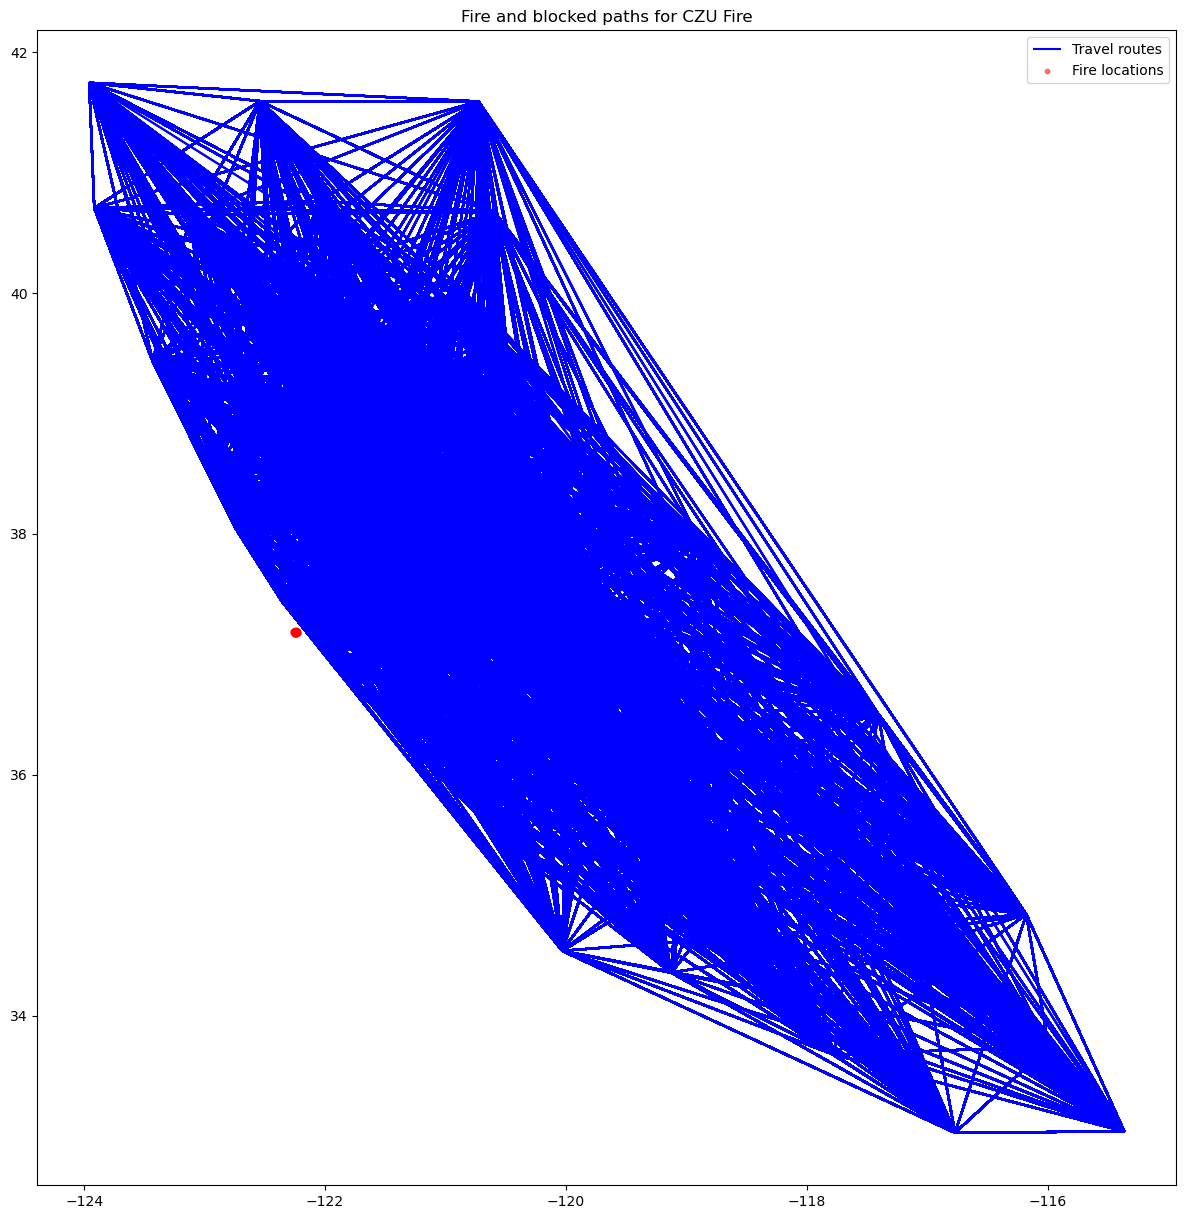

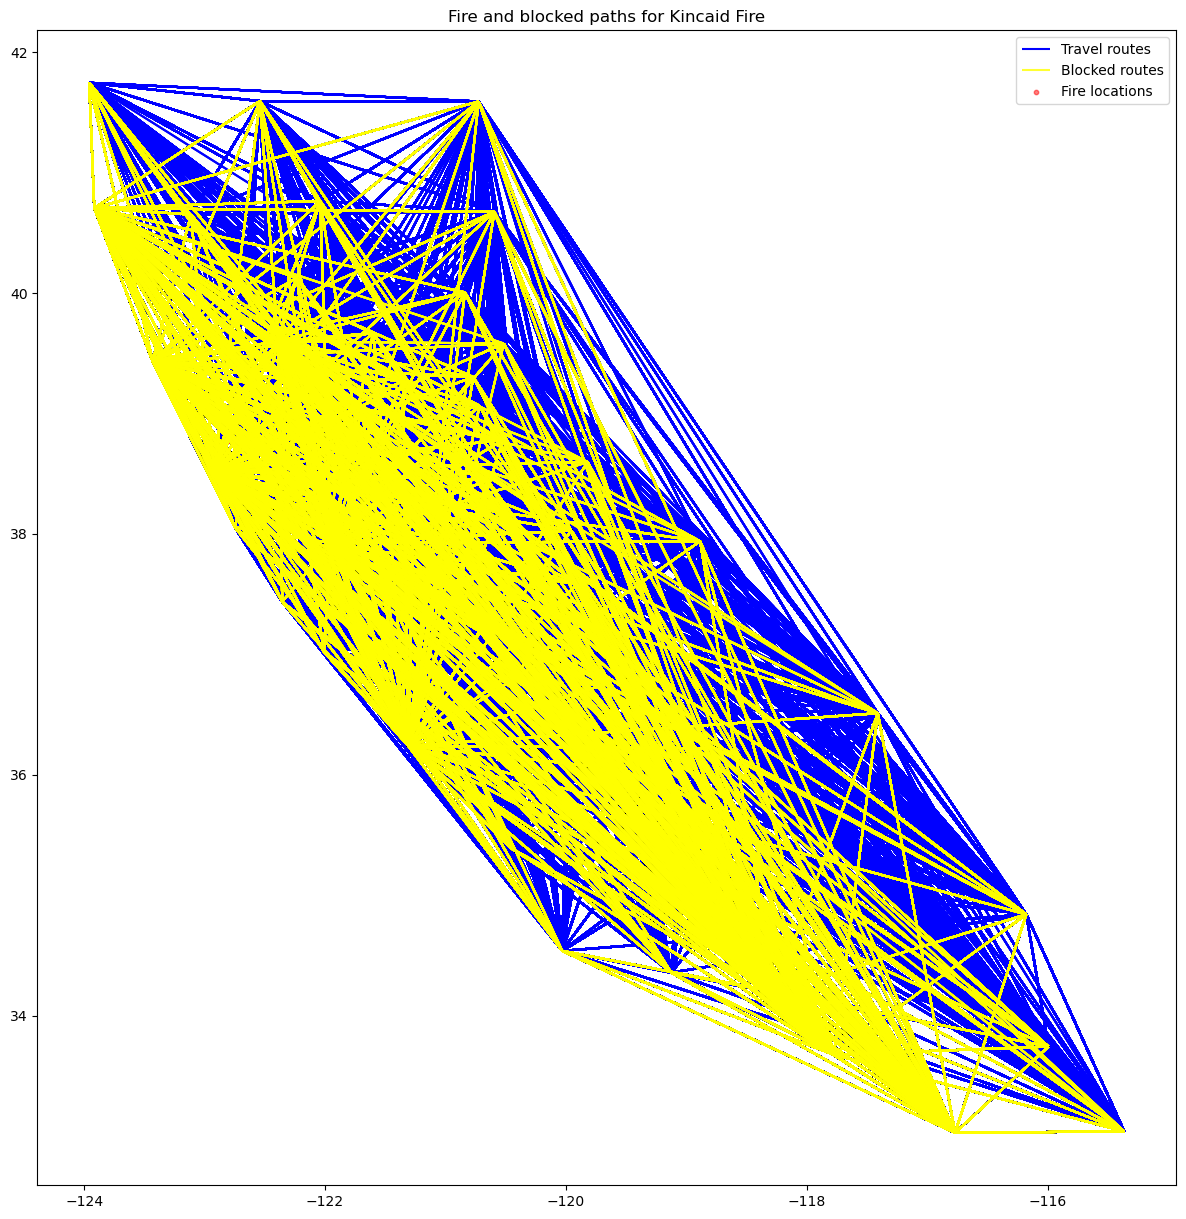

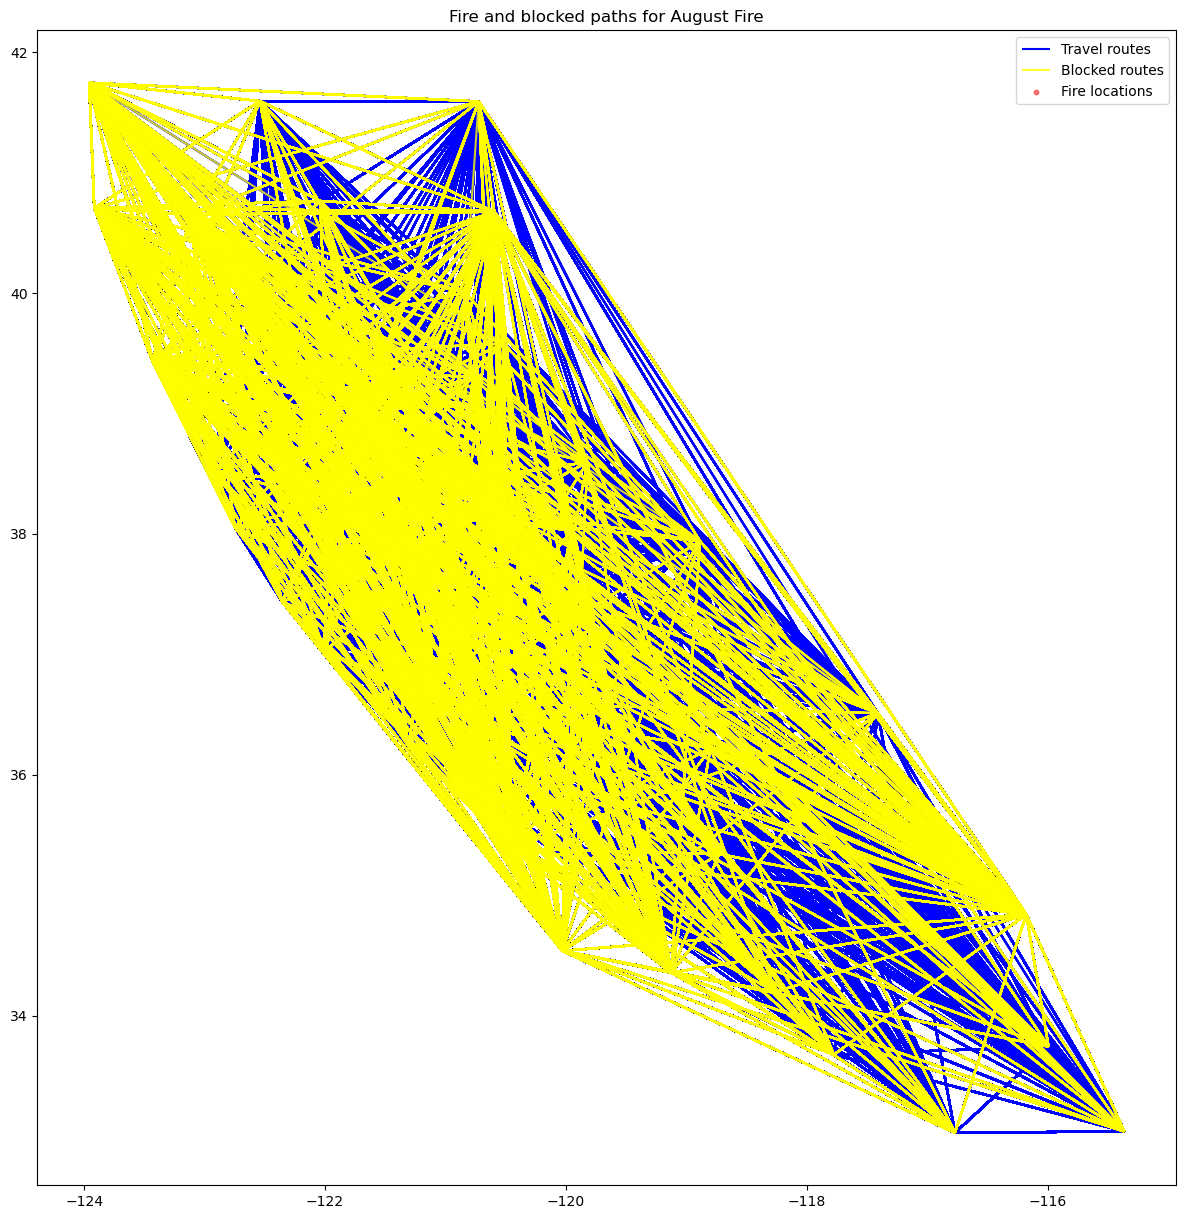

In [134]:
import json
import matplotlib.pyplot as plt

def plot_data(df_fire, df_travel, df_travel_blocked, fire_name):
    # Convert to GeoDataFrames
    geometry_fire = [Point(xy) for xy in zip(df_fire.longitude, df_fire.latitude)]
    gdf_fire = gpd.GeoDataFrame(df_fire, geometry=geometry_fire)

    geometry_travel = [LineString([(row['lng_o'], row['lat_o']), (row['lng_d'], row['lat_d'])]) for idx, row in df_travel.iterrows()]
    gdf_travel = gpd.GeoDataFrame(df_travel, geometry=geometry_travel)
    
    df_travel_blocked = df_travel_blocked[df_travel_blocked['blocked'] == True]
    gdf_travel_blocked = gpd.GeoDataFrame(df_travel_blocked, geometry=df_travel_blocked['geometry'])


    # Create plot
    fig, ax = plt.subplots(figsize=(15, 15))
    gdf_travel.plot(ax=ax, color='blue', label='Travel routes')
    gdf_travel_blocked.plot(ax=ax, color='yellow', label='Blocked routes', alpha=0.8)
    gdf_fire.plot(ax=ax, color='red', markersize=10, label='Fire locations', alpha=0.5)
    plt.title(f'Fire and blocked paths for {fire_name}')
    plt.legend()
    plt.show()


# Plot for each fire
plot_data(df_fire_czu, df_travel, df_travel_czu_blocked, 'CZU Fire')
plot_data(df_fire_kincaid, df_travel, df_travel_kincaid_blocked, 'Kincaid Fire')
plot_data(df_fire_august, df_travel, df_travel_august_blocked, 'August Fire')


In [135]:
with open('data/august_fire_polygons.geojson', 'r') as file:
    geojson = json.load(file)

dates = []
areas = []

for feature in geojson['features']:
    # Extract the acquisition date and convert it to a datetime object
    date_str = feature['properties']['acq_date']
    date = datetime.datetime.strptime(date_str, '%Y-%m-%dT%H:%M:%S')
    dates.append(date)
    
    # Calculate the area of the polygon and convert it to square kilometers
    geom = shape(feature['geometry'])
    area = geom.area / 1_000_000  # Convert from square meters to square kilometers
    areas.append(area)


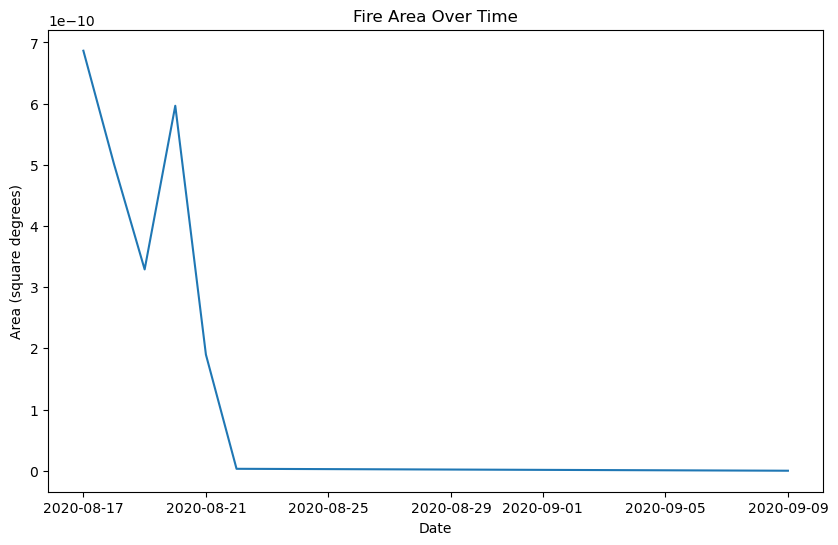

In [136]:
# Create a DataFrame
df = pd.DataFrame({'Date': dates, 'Area': areas})

# Sort the DataFrame by date
df.sort_values('Date', inplace=True)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Area'])
plt.xlabel('Date')
plt.ylabel('Area (square degrees)')
plt.title('Fire Area Over Time')
plt.show()

In [137]:
# import networkx as nx

# # Construct a graph from the travel dataframe
# G = nx.from_pandas_edgelist(df_travel, 'lat_o', 'lat_d', create_using=nx.Graph())

# # Get blocked edges from the dataframe
# blocked_edges = df_travel[df_travel['blocked'] == 1][['lat_o', 'lat_d']].values

# # Remove blocked edges from the graph
# G.remove_edges_from(blocked_edges)